In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from synthsne import C_

root_folder = '../save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SAMPLER)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../save)
(0) - ../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe/train/samplers.smplr - 6.604[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../save)
(0) - ../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe/train/samplers.smplr - 6.604[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [5]:
%load_ext autoreload
%autoreload 2
from synthsne import curve_statistics as cs

lcset_name = 'train'
methods = ['linear', 'bspline', 'uniformprior', 'curvefit', 'mcmc']
#methods = ['curvefit', 'mcmc']
#methods = ['linear', 'bspline']
rootdir = f'../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe/{lcset_name}'
method = 'curvefit' # linear, bspline
cs.get_all_incorrects_fittings(rootdir, method)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['ZTF20aavpnlv', 'ZTF18acbwtnh']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
t0 = pm.Normal('t0', mu=2.837163078517161, sigma=7.295084382370506) # SNIbc-g


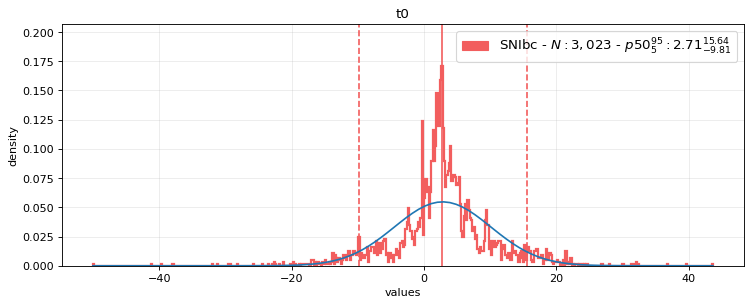

t0 = pm.Normal('t0', mu=3.9425404454205886, sigma=6.8078170617117) # SNIbc-r


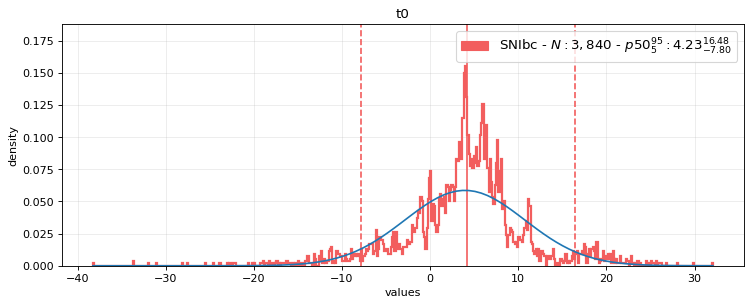

A = pm.Gamma('A', alpha=1.5699561643240227, beta=3.748189264177206) # SNIbc-g


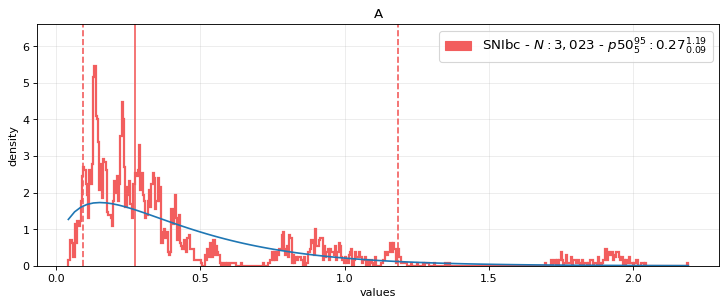

A = pm.Gamma('A', alpha=1.3404942674062685, beta=2.6231047812622315) # SNIbc-r


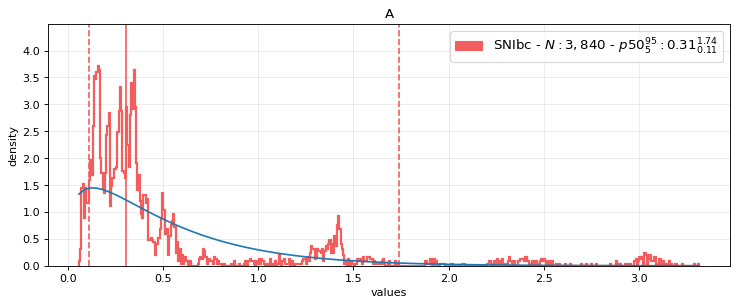

gamma = pm.Gamma('gamma', alpha=3.766010730103282, beta=0.13763909166403007) # SNIbc-g


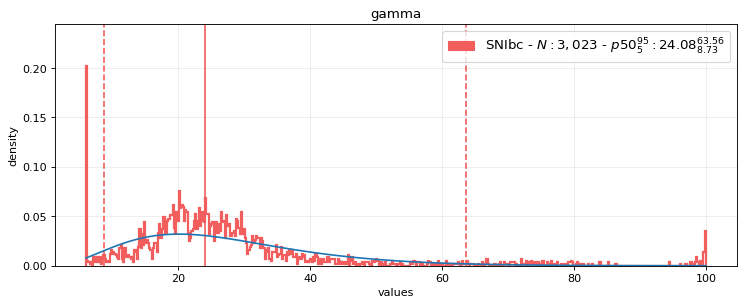

gamma = pm.Gamma('gamma', alpha=5.300059777891605, beta=0.15135870008933613) # SNIbc-r


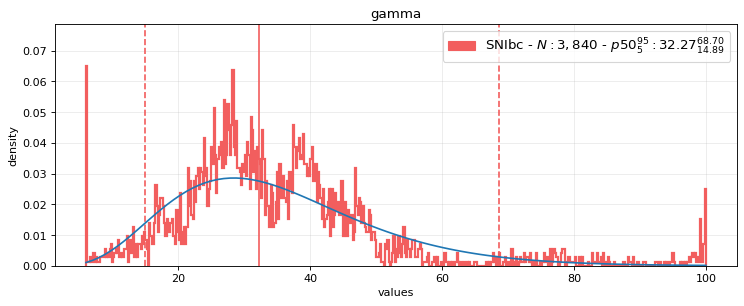

f = pm.Beta('f', alpha=2.789146451899514, beta=0.7810836157961726) # SNIbc-g


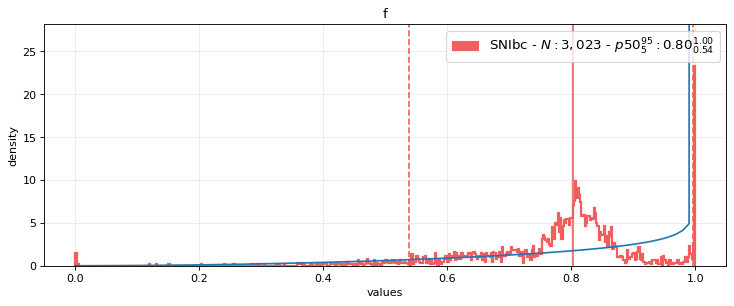

f = pm.Beta('f', alpha=2.528833097370183, beta=0.8584861614053972) # SNIbc-r


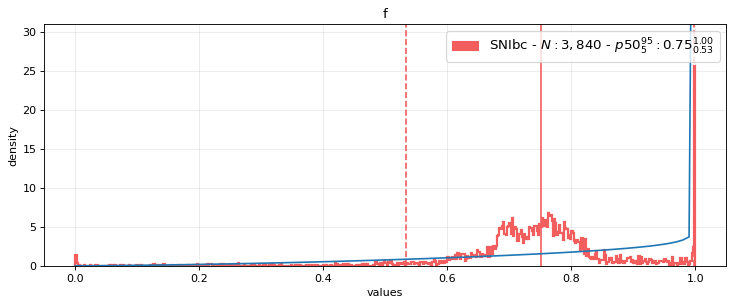

trise = pm.Gamma('trise', alpha=1.6203508246719265, beta=0.400089229126099) # SNIbc-g


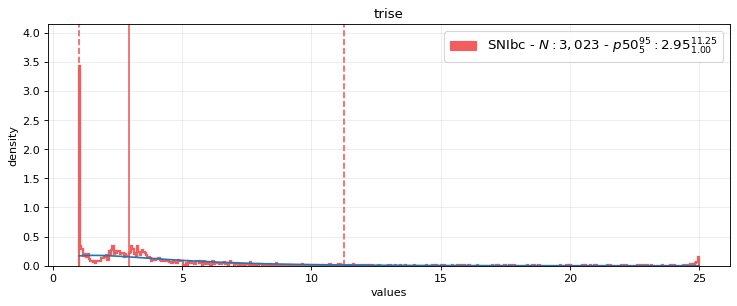

trise = pm.Gamma('trise', alpha=2.5919586924994262, beta=0.613397396232734) # SNIbc-r


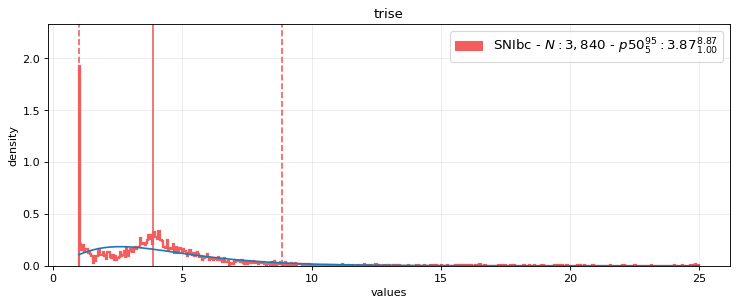

tfall = pm.Gamma('tfall', alpha=2.075397248359407, beta=0.04421687415890626) # SNIbc-g


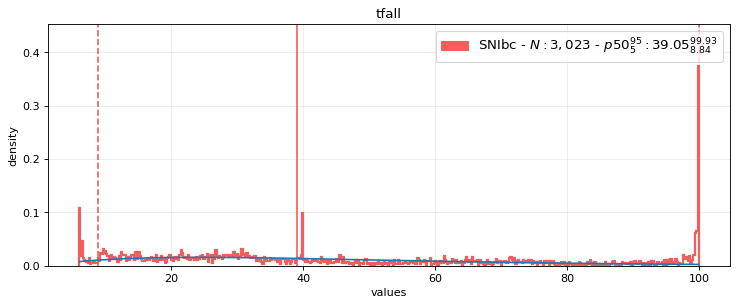

tfall = pm.Gamma('tfall', alpha=2.08444795990618, beta=0.04553955202427896) # SNIbc-r


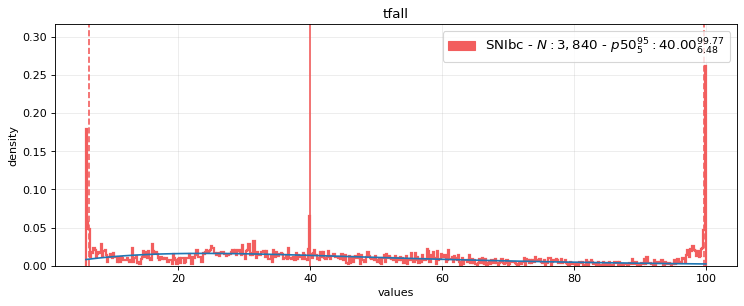

In [110]:
%load_ext autoreload
%autoreload 2
from synthsne import curve_statistics as cs
from flamingchoripan.cuteplots.plots import plot_hist_bins
import matplotlib.pyplot as plt
import scipy
import numpy as np
import scipy.stats

def xaa(spm_p, dist_name, dist_params):
    if dist_name=='norm':
        return f"{spm_p} = pm.Normal('{spm_p}', mu={dist_params[0]}, sigma={dist_params[1]})"
    elif dist_name=='gamma':
        return f"{spm_p} = pm.Gamma('{spm_p}', alpha={dist_params[0]}, beta={1/dist_params[2]})"
    elif dist_name=='beta':
        return f"{spm_p} = pm.Beta('{spm_p}', alpha={dist_params[0]}, beta={dist_params[1]})"

spm_d = {
    't0':'norm',
    'A':'gamma',
    'gamma':'gamma',
    'f':'beta',
    'trise':'gamma',
    'tfall':'gamma',
}
classes = cs.get_classes(rootdir, method)
#classes = ['SNIa', 'allSNII']
classes = ['SNIbc']#, 'SLSN']
for spm_p in spm_d.keys():
    for c in classes:
        for b in ['g', 'r']:
            spm_args_b = cs.xxx(rootdir, method, b)[spm_p]
            p = [spm_arg['p'] for spm_arg in spm_args_b if c==spm_arg['c']]
            data_dict = {c:p}
            fig, ax = plot_hist_bins(data_dict, uses_density=1, title=spm_p)
            
            dist_name = spm_d[spm_p]
            if not dist_name is None:
                dist = getattr(scipy.stats, dist_name)
                floc = None if dist_name in ['norm'] else 0
                fscale = None if dist_name in ['norm', 'gamma'] else 1
                dist_params = dist.fit(p, floc=floc, fscale=fscale)
                x = np.linspace(np.min(p), np.max(p), 100)
                ax.plot(x, dist.pdf(x, *dist_params))
                print(f'{xaa(spm_p, dist_name, dist_params)} # {c}-{b}')
                
            plt.show()

In [4]:
%load_ext autoreload
%autoreload 2
from synthsne import curve_statistics as c

for method in methods:
    xe = cs.get_perf_times(rootdir, method)
    print(f'{method} ({len(xe)}): {xe}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
linear (1549): .45±.09
bspline (1549): .50±.15
uniformprior (1541): .91±.30
curvefit (1549): 7.46±3.68
mcmc (854): 301.56±118.75


In [5]:
%load_ext autoreload
%autoreload 2
from synthsne import curve_statistics as cs

method = 'linear'
rank, rank_bdict, band_names = cs.get_ranks(rootdir, method)
print(rank)
for b in band_names:
    print(rank_bdict[b])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
mb-rank[top10]:
(1) - ZTF19acckggd: 47,902.5694
(2) - ZTF19abnagzk: 6,206.0634
(3) - ZTF20aazdxlx: 882.3671
(4) - ZTF19acuyvtl: 653.3272
(5) - ZTF20aabqisb: 573.2080
(6) - ZTF20aamuqwn: 569.1171
(7) - ZTF18aasdted: 367.6000
(8) - ZTF19abcunya: 340.0557
(9) - ZTF18acqyvag: 317.5996
(10) - ZTF20aaxvzja: 261.4015
g-rank[top10]:
(1) - ZTF19acckggd: 95,754.8399
(2) - ZTF19abnagzk: 12,361.7331
(3) - ZTF20aazdxlx: 1,711.7904
(4) - ZTF19acuyvtl: 1,257.2938
(5) - ZTF20aabqisb: 1,091.3124
(6) - ZTF19abcunya: 633.7771
(7) - ZTF20aamuqwn: 569.1171
(8) - ZTF20aaxvzja: 472.7951
(9) - ZTF20aasokxu: 385.3987
(10) - ZTF18aasdted: 382.4001
r-rank[top10]:
(1) - ZTF18acqyvag: 588.7087
(2) - ZTF18aasdted: 352.7999
(3) - ZTF18abuqugw: 190.5685
(4) - ZTF19acihlft: 171.8716
(5) - ZTF18aaqkdwf: 171.4280
(6) - ZTF19acgfowd: 168.7509
(7) - ZTF19aaxnlps: 168.4566
(8) - ZTF19acrwzqs: 154.3815
(9) - ZTF19aawgopm: 154.0262
(10) -

In [21]:
%load_ext autoreload
%autoreload 2
from synthsne import curve_statistics as cs
from flamingchoripan.latex.latex_tables import LatexTable

info_df = cs.get_info_dict(rootdir, methods)

latex_kwargs = {
    'caption':'$x_j$',
    'label':'???',
    'bold_criteriums':{c:'max' if ('%' in c or 'fits-n' in c) else 'min' for c in info_df.columns},
    'custom_tabular_align':'l|c|ccc|ccc|ccc',
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
info_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{$x_j$}
\label{???}\vspace{.1cm}
\begin{tabular}{l|c|ccc|ccc|ccc}
\hline
method & trace-time[segs] & mb-fit-log-error & mb-fits-n & mb-fits[\%] & g-fit-log-error & g-fits-n & g-fits[\%] & r-fit-log-error & r-fits-n & r-fits[\%] \srule\\\hline\hline
linear & \textbf{.45$\pm$.09} & 3.89$\pm$.45 & 185,639 & 93.51 & 3.88$\pm$.49 & 88,687 & 89.34 & 3.90$\pm$.40 & \textbf{96,952} & \textbf{97.67}  \srule\\
bspline & .50$\pm$.15 & 5.81$\pm$2.55 & 185,621 & 93.50 & 5.88$\pm$2.82 & 88,707 & 89.36 & 5.75$\pm$2.26 & 96,914 & 97.63  \srule\\
uniformprior & .91$\pm$.31 & 7.86$\pm$1.10 & 181,376 & 91.36 & 7.99$\pm$1.13 & 85,120 & 85.75 & 7.74$\pm$1.05 & 96,256 & 96.97  \srule\\
curvefit & 7.45$\pm$3.69 & 4.11$\pm$.89 & \textbf{185,6

,trace-time[segs],mb-fit-log-error,mb-fits-n,mb-fits[%],g-fit-log-error,g-fits-n,g-fits[%],r-fit-log-error,r-fits-n,r-fits[%]
method=linear,.45±.09,3.89±.45,185639,93.507717,3.88±.49,88687,89.344576,3.90±.40,96952,97.670858
method=bspline,.50±.15,5.81±2.55,185621,93.498650,5.88±2.82,88707,89.364724,5.75±2.26,96914,97.632576
method=uniformprior,.91±.31,7.86±1.10,181376,91.360413,7.99±1.13,85120,85.751128,7.74±1.05,96256,96.969697
method=curvefit,7.45±3.69,4.11±.89,185644,93.510235,3.96±.88,88715,89.372784,4.25±.88,96929,97.647687
method=mcmc,272.56±118.42,3.35±1.08,181376,91.360413,3.15±1.09,85120,85.751128,3.52±1.05,96256,96.969697
